# Read In History Data

In [9]:
# load packages that are required
from datasketch import MinHash, MinHashLSH
import pandas as pd
import numpy as np
import pickle
import time
import csv
import random as rd
from scipy.stats import pearsonr
import math

In [10]:
data = pd.read_csv("train_data.csv")
description = pd.read_csv("description.csv")

In [11]:
with open('kcluster.pickle', 'rb') as handle:
    kcluster = pickle.load(handle)

In [278]:
a = description.loc[kcluster[0]]['asin'].values.tolist()
table = data.loc[data['asin'].isin(a)][['asin', 'reviewer', 'star_rating']]
df = pd.pivot_table(table, index='reviewer', columns='asin', values='star_rating',fill_value=0)

# LSH Candidate Set Calculation

In [150]:
def getLSHCandidateSets(df, t):
    #create LSH objective, one important hyper parameter: threshold for LSH
    lsh = MinHashLSH(threshold=t, num_perm=128) 
    minHashes = pd.Series(index = df.columns)
    
    #update minhash for every item
    for item in df.columns:
        minH = MinHash(num_perm = 128)
        for rate in df[item]:
            minH.update(str(rate).encode('utf8'))
        lsh.insert(item, minH)
        minHashes.loc[item] = minH
    
    #query candidate neighbors
    candidate_neighbors = {}
    for user in df.columns:
        candidate_neighbors[user] = lsh.query(minHashes.loc[user])
        
    return candidate_neighbors

# Item Based Collaborative Filtering KNN Model With LSH

In [257]:
# for evaluating model
def item_based_CF_evaluate(train, test, k, t):
    #tStart = time.time()
    #calculate candidates
    candidates = getLSHCandidateSets(train,t)
    #print "Candidates calculated"
    
    neighbors = {}
    similarity = {}
    for item in test.columns:
        sim = pd.Series(index = candidates[item])
        for c in candidates[item]:
            sim.loc[c] = pearsonr(train[item],train[c])[0]
        sim = sim.sort_values(ascending=False)[1:k+1]
        knn = sim.index
        user_index = test[test[item]>0].index
        neighbors[item] = pd.DataFrame(index = user_index)
        neighbors[item] = neighbors[item].add(train.loc[user_index, knn], axis = 'columns')

        similarity[item] = sim
    
    tuples = []
    predict = pd.DataFrame(data= train, dtype=float)
    for item in test.columns:
        if train[train[item]>0][item].count()==0:
            uMean = train.sum().sum()/train[train>0].count().sum()
        else:
            uMean = train[train[item]>0][item].mean()
        for u in neighbors[item].index:
            sumSim = sum([abs(similarity[item].loc[nn]) for nn in neighbors[item].columns if train.loc[u,nn]!=0])
            if(sumSim > 0):
                sumDif = sum([(train.loc[u,nn] - train[train[nn]>0][nn].mean())*similarity[item].loc[nn] for nn in neighbors[item].columns if train.loc[u,nn]!=0])
                predict.loc[u,item] = uMean +  sumDif / sumSim
            else:
                predict.loc[u,item] = uMean

            if(predict.loc[u,item] >5):
                predict.loc[u,item] = 5
            if(predict.loc[u,item] <1):
                predict.loc[u,item] = 1
            
            tuples.append((item,u,predict.loc[u,item],test.loc[u,item]))
                
    #print 'Time: '+ str(time.time()-tStart)
    return predict,tuples

In [255]:
#for predict unknown ratings
from scipy.stats import pearsonr
import math
def item_based_CF_predict(df, k, t):
    #calculate candidates
    candidates = getLSHCandidateSets(df,t)
    #print 'Candidates calculated'
    
    neighbors = {}
    similarity = {}
    for item in df.columns:
        sim = pd.Series(index = candidates[item])
        for c in candidates[item]:
            sim.loc[c] = pearsonr(df[item],df[c])[0]
        sim = sim.sort_values(ascending=False)[1:k+1]
        knn = sim.index
        user_index = df[df[item]==0].index
        neighbors[item] = pd.DataFrame(index = user_index)
        neighbors[item] = neighbors[item].add(df.loc[user_index, knn], axis = 'columns')

        similarity[item] = sim
    
    #print 'Similarity calculated'
    
    tuples = []
    predict = pd.DataFrame(data= df, dtype=float)

    for item in df.columns:
        #print item

        if df[df[item]>0][item].count()==0:
            uMean = df.sum().sum()/df[df>0].count().sum()
        else:
            uMean = df[df[item]>0][item].mean()
        for u in neighbors[item].index:
            sumSim = sum([abs(similarity[item].loc[nn]) for nn in neighbors[item].columns if df.loc[u,nn]!=0])
            if(sumSim > 0):
                sumDif = sum([(df.loc[u,nn] - df[df[nn]>0][nn].mean())*similarity[item].loc[nn] for nn in neighbors[item].columns if df.loc[u,nn]!=0])
                predict.loc[u,item] = uMean +  sumDif / sumSim
            else:
                predict.loc[u,item] = uMean

            if(predict.loc[u,item] >5):
                predict.loc[u,item] = 5
            if(predict.loc[u,item] <1):
                predict.loc[u,item] = 1

            tuples.append((item,u,predict.loc[u,item]))
            
    return predict, tuples

# Evaluation About Accuracy and Coverage

### The accuracy of prediction is measured by two popular error functions: MAE, RMSE. 

### And the coverage of recommendation is defined as the proportion of items that can be recommended to all users.

In [14]:
#calculate mae of prediction
def get_mae(pred, actual):
    pred = pred.as_matrix()
    actual = actual.as_matrix()
    
    pred = pred.flatten()[actual.flatten().nonzero()] 
    actual = actual.flatten()[actual.flatten().nonzero()]
    mae = sum(abs(pred - actual)) / len(pred)
    return round(mae, 4)

In [15]:
#calculate rmse of prediction
def get_rmse(pred, actual):
    pred = pred.as_matrix()
    actual = actual.as_matrix()
    # Ignore zero terms.
    pred = pred.flatten()[actual.flatten().nonzero()] 
    actual = actual.flatten()[actual.flatten().nonzero()]
    rmse = (sum((pred - actual)**2) / len(pred))**0.5
    return round(rmse, 4)

In [280]:
#calculate coverage of recommendation
def get_coverage(pred, df, k):
    reco = pred - df
    item_recommended = []
    for user in reco.index:
        topk = pred.loc[user,:].sort_values(ascending=False)[0:k].index.tolist()
        item_recommended += topk
    num_reco = len(set(item_recommended))
    num_total = pred.shape[1]
    #print num_reco, num_total
    return round(float(num_reco) / num_total, 4)

### The mean rating for an item is used as the baseline prediction in our project. And KNN with LSH model shows a much higher accuracy than baseline.

In [17]:
def baseline_mae(train,test):    
    # build baseline prediction
    column_sum = train.sum()
    column_num = train[train>0].count()
    column_avg = column_sum / column_num  # item mean
    pred_array = [column_avg]*train.shape[0]
    pred = pd.DataFrame(data = pred_array, index=train.index, columns=train.columns)
    
    # MAE,RMSE
    mae = get_mae(pred, test)
    rmse = get_rmse(pred, test)
    return 'MAE: ' + str(mae) + ' RMSE: ' + str(rmse)

In [147]:
baseline_mae(train,test)

'MAE: 1.1008 RMSE: 1.37'

## Evaluation through cross validation

In [16]:
# split data into train and test data
def split_dataset(df, per):
    train = df.copy()
    for row in df.index:
        col_index = (df.columns.values).tolist()
        rd.shuffle(col_index)
        # take per test data and (1-per) train data
        hidden_index = col_index[0: int(len(col_index)*per)]
        for col in hidden_index:
            train.loc[row, col] = 0
    test = df - train
    return train, test 

In [153]:
# divide data into four folders, and take the average result as the final result
def algo_evaluation(algo, folders, param1, param2):
    # run model
    tStart = time.time()
    for i in range(0,4):
        train, test = folders[i]['train'], folders[i]['test']
        pred = algo(train, test, param1, param2)
        folders[i]['mae'] = get_mae(pred, test)
        folders[i]['rmse'] = get_rmse(pred, test)
    
    #calculate the average mae,rmse,running time
    avg_mae = round((folders[0]['mae']+folders[1]['mae']+folders[2]['mae']+folders[3]['mae'])/4,4)
    avg_rmse = round((folders[0]['rmse']+folders[1]['rmse']+folders[2]['rmse']+folders[3]['rmse'])/4,4)
    run_time = (time.time()-tStart)
    return avg_mae,avg_rmse,run_time

## Other Evaluation

### First, with the augment of data size, the efficiency performance are taken into our account. So we find the relationship between running time and data size.

In [220]:
def performance_datasize(categoryNum):
    time_list = []
    
    for i in range(0,categoryNum):
        a = description.loc[kcluster[i]]['asin'].values.tolist()
        table = data.loc[data['asin'].isin(a)][['asin', 'reviewer', 'star_rating']]
        df = pd.pivot_table(table, index='reviewer', columns='asin', values='star_rating',fill_value=0)    
        if(df.shape[0]<1000 or df.shape[0]>3000):
            continue
        print i
        tStart = time.time()
        #train,test = split_dataset(df,0.2)
        pred,tuples = item_based_CF_predict(df,10,0.6)
        #pred = item_based_CF_evaluate(train,test,10,0.6)
        time_list.append([df.shape[1],time.time()-tStart])
        
    time_df = pd.DataFrame(data = time_list, columns = ['size','time'])
        
    return time_df

/Users/jingyiwang/anaconda2/envs/vir/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


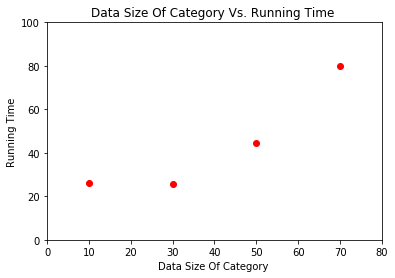

In [227]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.xlabel('Data Size Of Category ')
plt.ylabel('Running Time')
plt.title('Data Size Of Category Vs. Running Time ')
time_list = []

for i in range(0,6):
    t = time_df[time_df['size'] >i*20][time_df['size']<= (i+1)*20]['time'].mean()
    plt.plot((i+1)*20-10, t, 'ro')
    
plt.axis([0,80,0,100])
plt.show()

### Seocnd, the coverage  is evaluated according to the number of items we plan to recommend for each user.

In [199]:
# topklist contains the values we want to try
def coverage_evaluate(df, topklist):
    covlist = []
    pred, tuples = item_based_CF_predict(df, 10, 0.6)
    for k in topklist:
        covlist.append(get_coverage(pred,df,k))
    return covlist

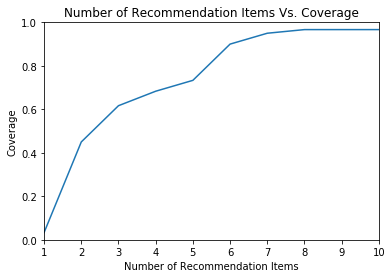

In [281]:
a = description.loc[kcluster[0]]['asin'].values.tolist()
table = data.loc[data['asin'].isin(a)][['asin', 'reviewer', 'star_rating']]
df = pd.pivot_table(table, index='reviewer', columns='asin', values='star_rating',fill_value=0)
topklist = [1,2,3,4,5,6,7,8,9,10]
covlist = coverage_evaluate(df, topklist)

import matplotlib.pyplot as plt
%matplotlib inline
plt.xlabel('Number of Recommendation Items')
plt.ylabel('Coverage')
plt.title('Number of Recommendation Items Vs. Coverage')
plt.plot(topklist, covlist)
plt.axis([1, 10, 0, 1])
plt.show()

# Hyper Parameter Tuning

## The number of nearest neighbors k is one of the important hyper parameter, and it is an input to the traditional KNN model.

In [109]:
# klist contains the values we want to try
def k_neighbor_tune(df, klist):
    mae_list = []
    rmse_list = []
    time_list = []
    
    #cross_validation: split train data
    folders = []
    for i in range(0,4):
        folders.append({})
        train, test = split_dataset(df, 0.2) # 80% train, 20% test
        folders[i]['train'] = train
        folders[i]['test'] = test
    #print "split completed"
    
    for k in klist:
        #print k
        mae, rmse,runtime = algo_evaluation(item_based_CF_evaluate, folders, k, 0.5)
        mae_list.append(mae)
        rmse_list.append(rmse)
        time_list.append(runtime)
        
    return mae_list, rmse_list, time_list

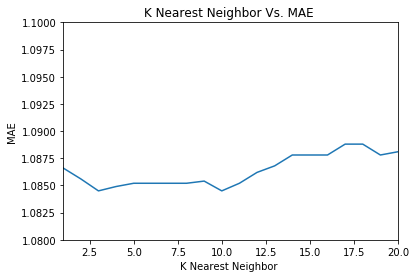

In [120]:
# use cluster0 as our test data set
a = description.loc[kcluster[0]]['asin'].values.tolist()
table = data.loc[data['asin'].isin(a)][['asin', 'reviewer', 'star_rating']]
df = pd.pivot_table(table, index='reviewer', columns='asin', values='star_rating',fill_value=0)
klist = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
mae_list,rmse_list,time_list = k_neighbor_tune(df, klist)

import matplotlib.pyplot as plt
%matplotlib inline
plt.xlabel('K Nearest Neighbor ')
plt.ylabel('MAE')
plt.title('K Nearest Neighbor Vs. MAE ')
plt.plot(klist, mae_list)
plt.axis([klist[0], klist[len(klist)-1], 1.08, 1.10])
plt.show()

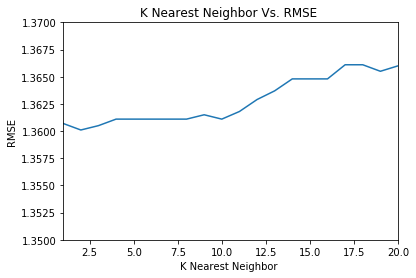

In [125]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.xlabel('K Nearest Neighbor ')
plt.ylabel('RMSE')
plt.title('K Nearest Neighbor Vs. RMSE ')
plt.plot(klist, rmse_list)
plt.axis([klist[0], klist[len(klist)-1], 1.35, 1.37])
plt.show()

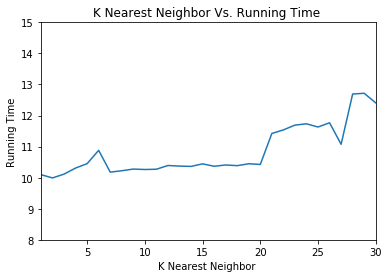

In [145]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.xlabel('K Nearest Neighbor ')
plt.ylabel('Running Time')
plt.title('K Nearest Neighbor Vs. Running Time ')
plt.plot(klist, time_list)
plt.axis([klist[0], klist[len(klist)-1], 8, 15])
plt.show()

## Threshold for LSH is the other hyper parameter we have interest in, which has influence on the size of candidate sets.

In [152]:
# tlist contains the values we want to try
def threshold_tune(df, tlist):
    mae_list = []
    rmse_list = []
    time_list = []
    
    #cross_validation: split train data
    folders = []
    for i in range(0,4):
        folders.append({})
        train, test = split_dataset(df, 0.2) # 80% train, 20% test
        folders[i]['train'] = train
        folders[i]['test'] = test
    #print "split completed"
    
    for t in tlist:
        #print t
        mae, rmse,runtime = algo_evaluation(item_based_CF_evaluate, folders, 10, t)
        mae_list.append(mae)
        rmse_list.append(rmse)
        time_list.append(runtime)
        
    return mae_list, rmse_list, time_list

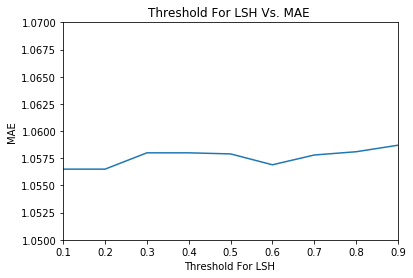

In [161]:
# use cluster0 as our test data set
a = description.loc[kcluster[0]]['asin'].values.tolist()
table = data.loc[data['asin'].isin(a)][['asin', 'reviewer', 'star_rating']]
df = pd.pivot_table(table, index='reviewer', columns='asin', values='star_rating',fill_value=0)
tlist = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
mae_list,rmse_list,time_list = threshold_tune(df, tlist)

import matplotlib.pyplot as plt
%matplotlib inline
plt.xlabel('Threshold For LSH ')
plt.ylabel('MAE')
plt.title('Threshold For LSH Vs. MAE ')
plt.plot(tlist, mae_list)
plt.axis([tlist[0], tlist[len(tlist)-1], 1.05, 1.07])
plt.show()

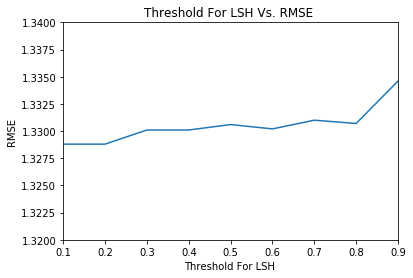

In [167]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.xlabel('Threshold For LSH ')
plt.ylabel('RMSE')
plt.title('Threshold For LSH Vs. RMSE ')
plt.plot(tlist, rmse_list)
plt.axis([tlist[0], tlist[len(tlist)-1], 1.32, 1.34])
plt.show()

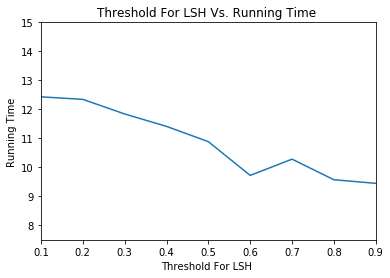

In [171]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.xlabel('Threshold For LSH ')
plt.ylabel('Running Time')
plt.title('Threshold For LSH Vs. Running Time ')
plt.plot(tlist, time_list)
plt.axis([tlist[0], tlist[len(tlist)-1], 7.5, 15])
plt.show()

# Offline prediction computation for hybrid model

In [108]:
# in category file
def in_category_LSH_kNN_predict():
    output = dict()
    for i in range(0,100):
        print i
        a = description.loc[kcluster[i]]['asin'].values.tolist()
        table = data.loc[data['asin'].isin(a)][['asin', 'reviewer', 'star_rating']]
        df = pd.pivot_table(table, index='reviewer', columns='asin', values='star_rating',fill_value=0)
        
        pred, output[i] = item_based_CF_predict(df, 10)
        
    with open('within_category_result.csv','wb') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['reviewer','asin','rating'])
        for key in output.keys():
            for row in output[key]:
                csv_out.writerow(row)
        

In [17]:
# cross category file
def cross_category_LSH_kNN_predict():
    data = pd.read_csv('df_101.csv',index_col = 'cluster')
    df = data.T
    pred, output = item_based_CF_predict(df,10)
    with open('inclass_result.csv','wb') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['reviewer','cluster','rating'])
        for row in output:
            csv_out.writerow(row)